# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable
from IPython.display import clear_output
import math


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 64
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True

# transform = transforms.Compose([transforms.ToTensor()])



# Normalize input images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2),  # Reverse the normalization to get values in [0, 1]
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.Lambda(lambda x: x.permute(1, 2, 0))
])


# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# COSINE SCHEDULE
def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return (torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2)).clamp(max=0.99999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([(f(t)/f(torch.tensor([0]))).clamp(max=0.99999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((T, 1, 1, 1)).to(device)
beta = beta.view((T, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)

In [ ]:
# Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
# LINEAR SCHEDULE
"""T = 1000
beta_start, beta_end = [1e-4, 2e-02]
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1-beta
alpha_bar = alpha.clone()
for e in range(T-1):
    alpha_bar[e+1] *= alpha_bar[e]

alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)"""

## Model

In [4]:
import math
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        freqs = torch.exp(
            -torch.arange(half_dim, dtype=torch.float32) * math.log(10000) / half_dim
        ).to(t.device)
        angles = t[:, None] * freqs[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

In [5]:
class LinearTimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(LinearTimeEmbedding, self).__init__()
        self.projection = nn.Linear(1, embedding_dim)  # Project the scalar to the embedding dimension

    def forward(self, t):
        return self.projection(t.unsqueeze(-1))  # Add an extra dimension for the projection


In [6]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 32, 32))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 32, 32)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

## Training loop

In [7]:
#from UNET import UNET
epochs = 200
model = ScoreNetwork0()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0

# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = LinearTimeEmbedding(time_embedding_dim).to(device)

In [ ]:
for epoch in range(epochs+1):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        #print(t.shape)
        eps = torch.randn(batch_size, 3, 32, 32).to(device)
        # print(eps.shape)
        # print(x0.shape)
        loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                    torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32) / 1000))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            with open("losses", "a") as file:
                file.write(f"{running_loss:.3f}\n")
            
            running_loss = 0.0
        
    if epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400]:
        torch.save(model.state_dict(), f"DDPM_final_linear_{epoch}.pth")
torch.save(model.state_dict(), f"DDPM_final_linear_{epoch}.pth")

tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) tensor(-1.)
tensor(1.) 

KeyboardInterrupt: 

# Sampling

1.0 0.0


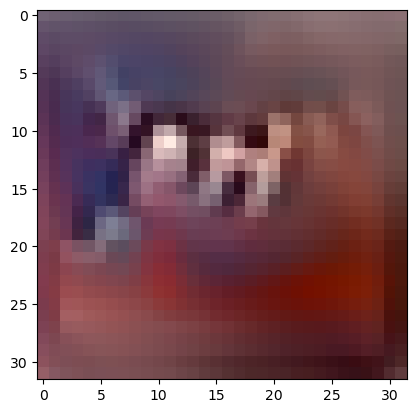

In [ ]:
model.eval()
batch_size = 1
xt = torch.randn(batch_size, 3, 32, 32).to(device)
for t in torch.arange(T, 0, -1):
    #print(t)
    t = t.to(device)
    z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
    xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                   model(xt, t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
    xt = xt_new
    #if t == 1:
        #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
im = xt[0].permute(1, 2, 0)
im = im.cpu().detach().numpy()
im = (im + 1) / 2 
im = im.clip(0, 1)
#print(im.max())
plt.imshow(im)

In [ ]:
pip install pytorch-fid
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm import tqdm

valid_dir = './valid_images'
test_dir = './test_images'
train_dir = './train_images'
gen_dir = './gen_images'
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(gen_dir, exist_ok=True)
#for epoch in [800, 1100, 1400, 1707]:
#    os.makedirs(f"./gen_images/{epoch}", exist_ok=True)

resize_transform = transforms.Resize((299, 299))

for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
    model = UNET()
    model.to(device)
    model.load_state_dict(torch.load(f"DDPM_final_linear_{epoch}.pth"))
    model.eval()
    batch_size = 1
    
    print("Starting generation set: ")
    for i in tqdm(range(1000)):
        xt = torch.randn(batch_size, 3, 32, 32).to(device)
        
        for t in torch.arange(T, 0, -1):
            #print(t)
            t = t.to(device)
            z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
            xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                           model(xt, t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
            xt = xt_new
            #if t == 1:
                #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
        im = xt[0]
        print(im.shape)
        im = resize_transform(im)
        im = (im + 1) / 2
        im = im.clamp(0, 1)
        print(im.shape)
        print("Saving generated image: ")
        save_image(im, os.path.join(f"./gen_images/{epoch}", f"{i}.png"))
        print(epoch, i)

# Calculate FID scores. 1 validation score per model until the last, where it calculates test and train FID score.

In [ ]:
from pytorch_fid import fid_score
validation_scores = []
test_score = []
train_score = []
for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"DDPM_final_linear_{epoch}.pth"))
        model.eval()
        if epoch != 1707:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./valid_images', f"./gen_images/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            validation_scores.append(fid_value)
        else:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./test_images', f"./gen_images/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            test_score.append(fid_value)
            fid_train_value = fid_score.calculate_fid_given_paths(
                ['./train_images', f"./gen_images/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            train_score.append(fid_train_value)
        print(f"epoch and valid FID Score: {epoch}, {validation_scores[-1]}")
        if epoch == 1707:
            print(f"epoch and test set FID Score: {epoch}, {test_score[0]}")
            print(f"epoch and train set FID Score: {epoch}, {train_score[0]}")

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.33it/s]


epoch and valid / test FID Score: 800, 121.40338087697023


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.25it/s]


epoch and valid / test FID Score: 1100, 123.71948282394982


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.49it/s]


epoch and valid / test FID Score: 1400, 117.25221250102305


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.40it/s]


epoch and valid / test FID Score: 1707, 107.45026541826462
epoch and train set FID Score: 1707, 107.8141066126903


# Get one training loss per epoch

In [ ]:
with open("losses.txt", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) / 10 for line in lines]
    indices = np.linspace(0, len(lines) - 1, 1707).astype(int)
    all_epochs_loss = [lines[i] for i in indices]

501

In [ ]:
#with open("losses_501toandwith1707.txt", "r") as file:
#    lines = file.readlines()
#    lines = [float(line.strip()) / 10 for line in lines]
#    indices = np.linspace(0, len(lines) - 1, 1207).astype(int)
#    last_1207_epochs_loss = [lines[i] for i in indices]
#len(last_1207_epochs_loss)
#first_500_epochs_loss.extend(last_1207_epochs_loss)

# Plot everything, remember to change title

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


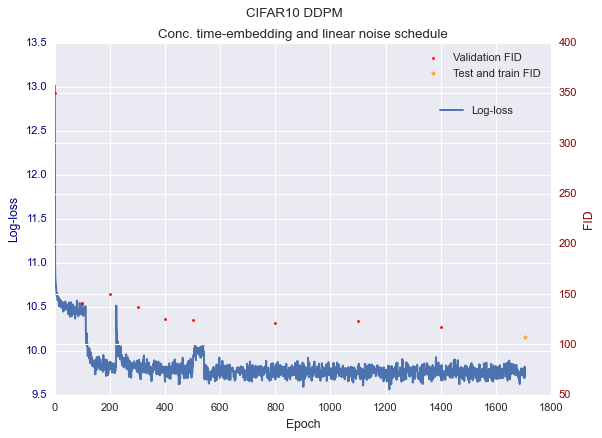

In [ ]:
#valid_fid_scores = [349.9, 141.6, 150.1, 137.1, 125.4, 124.3, 121.4, 123.7, 117.3]
#test_fid_score = [107.5]
#train_fid_score = [107.8]

epochs_valid_fid = validation_scores
epochs_loss = list(range(1707+1))
test_fid_score = test_score
train_fid_score = train_score
fig, ax1 = plt.subplots()
plt.suptitle("CIFAR10 DDPM")
plt.title("Conc. time-embedding and linear noise schedule")
ax1.plot(epochs_loss, np.log(np.array(first_500_epochs_loss)), label="Log-loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-loss', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.legend(loc="upper left", bbox_to_anchor=(0.757, 0.85))
ax2 = ax1.twinx()
ax2.scatter(epochs_valid_fid, valid_fid_scores, color="red", marker=".", label="Validation FID")
ax2.set_ylabel('FID', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.scatter([1707], test_fid_score, label="Test and train FID", marker="*", color="orange")
ax2.legend()


# Overfit one batch

In [ ]:
#from UNET import UNET

model = UNET().to(device)
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = LinearTimeEmbedding(time_embedding_dim).to(device)

# Get a single image from the batch
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(1, 1, 1, 1)
# Set the model to training mode
model.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
plot_every = 400

running_loss = 0
# Training loop to overfit one batch
epochs = 5000
for epoch in range(epochs):
    t = torch.randint(0, T, (1,), device=device)
    t_norm = t.float() / T # Normalize the time to [0, 1]
    t_emb = time_embedding_layer(t_norm)  # Shape: [1, embedding_dim]
    eps = torch.randn_like(single_batchs).to(device)
    x_t = torch.sqrt(alpha_bar[t]) * single_batchs + torch.sqrt(1 - alpha_bar[t]) * eps
    predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
    loss = criterion(predicted_eps, eps)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if epoch % 100 == 99:
        print(f"Epoch {epoch}, Average Loss: {running_loss / 100:.4f}")
        running_loss = 0.0  

    # if epoch % plot_every == 0:
    #     with torch.inference_mode():
    #         model.eval()
    #         t = torch.randint(0, T, (1,), device=device)
    #         t_emb = time_embedding_layer(t)
    #         eps = torch.randn_like(single_batch).to(device)
    #         x_t = torch.sqrt(alpha_bar[t]) * single_batch + torch.sqrt(1 - alpha_bar[t]) * eps
    #         predicted_eps = model(x_t, t_emb)
    #         reconstructed = x_t - predicted_eps
    #         fig, axs = plt.subplots(1, 3, tight_layout=True)
    #         axs[0].imshow(predicted_eps[0][0].cpu().detach().numpy(), cmap="gray")
    #         axs[0].set_title("Predicted Noise")
    #         axs[1].imshow(eps[0][0].cpu().detach().numpy(), cmap="gray")
    #         axs[1].set_title("True Noise")
    #         axs[2].imshow(np.abs(predicted_eps[0][0].cpu().detach().numpy()-eps[0][0].cpu().detach().numpy()), cmap="gray")
    #         axs[2].set_title("Difference in noise")
    #         plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47.826073 0.8980392
-29.50021 0.011764705


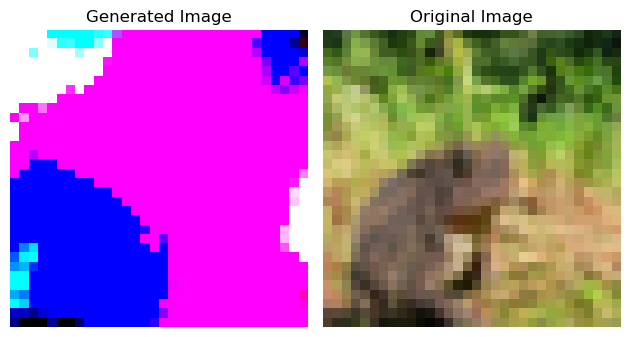

In [26]:
# Set the model to evaluation mode
model.eval()

# Initialize a random noise tensor
xt = torch.randn(1, 3, 32, 32).to(device)

# Perform the reverse diffusion process
with torch.no_grad():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1).to(device)
        t_emb = time_embedding_layer(t.float())
        z = torch.randn(1, 3, 32, 32).to(device) if t > 1 else torch.zeros(1, 3, 32, 32).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt = xt_new

# Plot the generated image
fig,axs = plt.subplots(1, 2, tight_layout=True)
im_1 = reverse_transform(xt[0].permute(1, 2, 0).cpu().detach().numpy())
axs[0].imshow(im_1)
axs[0].set_title("Generated Image")
axs[0].axis("off")
im_2 = reverse_transform(single_batch[0].permute(1, 2, 0).cpu().detach().numpy())
axs[1].imshow(im_2)
axs[1].set_title("Original Image")
axs[1].axis("off")
print(im_1.max(),im_2.max())
print(im_1.min(),im_2.min())
plt.show()